# Final Project Submission

* Student Name: **James Toop**
* Student Pace: **Self Paced**
* Scheduled project review date/time: **10th September 2020 - 3pm GMT**
* Instructor name: **Jeff Herman**
* Blog post URL: **TBC**

## Data Discovery and EDA

First step is to have a poke around in the data and see what data / fields we have and to see if we can create relationships between this disparate datasets or simply investigate each dataset separately.

As a reminder here are the data sources:

* Box Office Mojo
* IMDb
* Rotten Tomatoes
* TheMovieDB.org

In [2]:
# Import the relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Box Office Mojo dataset

#### Description

The [Box Office Mojo](https://www.boxofficemojo.com/) dataset provides us with Gross Income figures, both US Domestic and Foreign, by film title and studio between 2010 and 2018.  The Foreign Gross Income figures are less complete than the US Domestic figures.

#### EDA

* Which studios have been producing the most films?
* Year on year comparison of Gross Income (US Domestic and Foreign)? 


In [3]:
# Import the Box Office Mojo data and inspect the data types

df_bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz', compression='gzip', header=0, thousands=",")
df_bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null float64
year              3387 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


In [4]:
df_bom.describe()

,domestic_gross,foreign_gross,year
count,3.359000e+03,2.037000e+03,3387.000000
mean,2.874585e+07,7.487281e+07,2013.958075
std,6.698250e+07,1.374106e+08,2.478141
min,1.000000e+02,6.000000e+02,2010.000000
25%,1.200000e+05,3.700000e+06,2012.000000
50%,1.400000e+06,1.870000e+07,2014.000000
75%,2.790000e+07,7.490000e+07,2016.000000
max,9.367000e+08,9.605000e+08,2018.000000


In [5]:
df_bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010


In [6]:
# Handle missing values and datatypes to aide analysis

pd.set_option('display.max_rows', df_bom.shape[0]+1)
df_bom[['domestic_gross', 'foreign_gross']] = df_bom[['domestic_gross', 'foreign_gross']].fillna(0).astype(int)
df_bom[['year']] = df_bom[['year']].astype(str)
df_bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3387 non-null int64
foreign_gross     3387 non-null int64
year              3387 non-null object
dtypes: int64(2), object(3)
memory usage: 132.4+ KB


In [7]:
# Inspect incorrect looking data for the following films:

incorrect_df = df_bom[df_bom.title.isin(['The Fate of the Furious', 
                                         'Jurassic World',
                                         'Star Wars: The Force Awakens',
                                         'Furious 7',
                                         'Avengers: Infinity War'
                                        ])] 
incorrect_df

,title,studio,domestic_gross,foreign_gross,year
1872,Star Wars: The Force Awakens,BV,936700000,1131,2015
1873,Jurassic World,Uni.,652300000,1019,2015
1874,Furious 7,Uni.,353000000,1163,2015
2760,The Fate of the Furious,Uni.,226000000,1010,2017
3079,Avengers: Infinity War,BV,678800000,1369,2018


In [8]:
# Handle the incorrect foreign gross income data, out by a factor of 1,000,000 for the following films:
#  - The Fate of the Furious
#  - Jurassic World
#  - Star Wars: The Force Awakens
#  - Furious 7
#  - Avengers: Infinity War

df_bom.loc[df_bom.title.isin(['The Fate of the Furious',
                              'Jurassic World',
                              'Star Wars: The Force Awakens',
                              'Furious 7',
                              'Avengers: Infinity War'
                             ]) & (df_bom.foreign_gross < 1e6), 'foreign_gross'] = df_bom['foreign_gross'] * 1e6


corrected_df = df_bom[df_bom.title.isin(['The Fate of the Furious', 
                                         'Jurassic World',
                                         'Star Wars: The Force Awakens',
                                         'Furious 7',
                                         'Avengers: Infinity War'
                                        ])] 
corrected_df

,title,studio,domestic_gross,foreign_gross,year
1872,Star Wars: The Force Awakens,BV,936700000,1.131000e+09,2015
1873,Jurassic World,Uni.,652300000,1.019000e+09,2015
1874,Furious 7,Uni.,353000000,1.163000e+09,2015
2760,The Fate of the Furious,Uni.,226000000,1.010000e+09,2017
3079,Avengers: Infinity War,BV,678800000,1.369000e+09,2018


In [9]:
# Handle any potential duplicates within the dataset based on film title and studio and sort by year

df_bom = df_bom.sort_values('year').drop_duplicates(subset=['title', 'studio'])


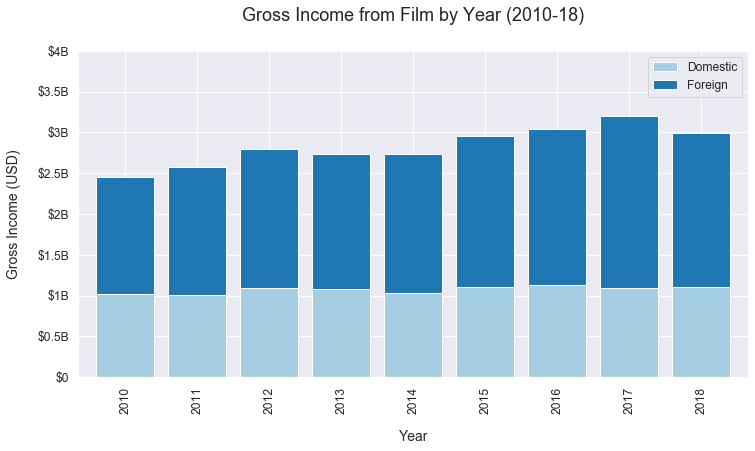

In [26]:
# Creating our first plot looking at Gross Income from Film year-on-year
sns.set(font_scale=1.1)
sns.set_palette(sns.color_palette("Paired"))

existing_yvalues = [0,0.5e10,1e10,1.5e10,2e10,2.5e10,3e10,3.5e10,4e10]
readable_yvalues = ['$0','$0.5B','$1B','$1.5B','$2B','$2.5B','$3B','$3.5B','$4B']
chart_data = df_bom[['year','domestic_gross','foreign_gross']].set_index('year').groupby('year').sum()
chart_data.plot(kind='bar', stacked=True, figsize=(12,6), width=0.8)
plt.ylim(0,4e10)
plt.yticks(existing_yvalues, readable_yvalues)
plt.title("Gross Income from Film by Year (2010-18)", fontsize=18, pad=30)
plt.xlabel("Year", fontsize=14, labelpad=16)
plt.ylabel("Gross Income (USD)", fontsize=14, labelpad=16)
plt.legend(['Domestic','Foreign'])

plt.show()

---

##  IMDb Dataset

#### Description

The [IMDb](https://www.imdb.com/) dataset provides us with data for Films released between 2010 and, according to the `describe()` below, 2115? although that could be some erroneous data. Fields include:

* Film Genre
* Average Rating
* Run Time
* Details of the Cast & Crew involved with the film

The data supplied is also relational so it makes sense to using SQLite for analysis.

#### EDA

* Number of films by genre
* Number of films by year and by genre

In [4]:
# Importing the data from IMDb for brief inspection starting with the Film Titles
df_imdb_titles = pd.read_csv('zippedData/imdb.title.basics.csv.gz', compression='gzip', header=0)

df_imdb_titles.info()
df_imdb_titles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
tconst             146144 non-null object
primary_title      146144 non-null object
original_title     146123 non-null object
start_year         146144 non-null int64
runtime_minutes    114405 non-null float64
genres             140736 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [5]:
df_imdb_titles.describe()

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [6]:
# Importing the Average Ratings data from IMDb for brief inspection
df_imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz', compression='gzip', header=0)

df_imdb_ratings.info()
df_imdb_ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
tconst           73856 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [8]:
# Importing the Average Ratings data from IMDb for brief inspection
df_imdb_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz', compression='gzip', header=0)

df_imdb_principals.info()
df_imdb_principals.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
tconst        1028186 non-null object
ordering      1028186 non-null int64
nconst        1028186 non-null object
category      1028186 non-null object
job           177684 non-null object
characters    393360 non-null object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [2]:
# Now let's create our database and data tables prior to importing the data

conn = sqlite3.connect('imdb-films.db')
c = conn.cursor()

# Create [film_titles] table
c.execute('''CREATE TABLE film_titles (
[tconst] text PRIMARY KEY,
[primary_title] text,
[original_title] text,
[start_year] text,
[runtime_minutes] integer,
[genres] text
)''')

# Create [film_ratings] table
c.execute('''CREATE TABLE film_ratings (
[tconst] text PRIMARY KEY,
[averagerating] float,
[numvotes] integer
)''')
          
conn.commit()

OperationalError: table film_titles already exists

In [6]:
# Use Pandas to import the data

conn = sqlite3.connect('imdb-films.db')  
c = conn.cursor()

read_film_titles = pd.read_csv (r'zippedData/imdb.title.basics.csv.gz', compression='gzip', header=0)
read_film_titles.to_sql('film_titles', conn, if_exists='append', index = False)

read_film_ratings = pd.read_csv (r'zippedData/imdb.title.ratings.csv.gz', compression='gzip', header=0)
read_film_ratings.to_sql('film_ratings', conn, if_exists='append', index = False)

In [13]:
c.execute("""
SELECT
`titles`.`primary_title`,
`titles`.`genres`,
`titles`.`start_year` AS `year`,
`ratings`.`averagerating`
FROM `film_titles` `titles`
INNER JOIN `film_ratings` `ratings` ON
`titles`.`tconst` = `ratings`.`tconst`
GROUP BY `titles`.`start_year`;
""")

df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,primary_title,genres,year,averagerating
0,Just Inès,Drama,2010,6.4
1,Até Onde?,"Mystery,Thriller",2011,6.5
2,21 Jump Street,"Action,Comedy,Crime",2012,7.2
3,Baggage Claim,Comedy,2013,5.1
4,The Legend of Hercules,"Action,Adventure,Fantasy",2014,4.2


---

##  Rotten Tomatoes Dataset

In [11]:
# Importing the csv files from Rotten Tomatoes - N.B. tab separated
df_rt = pd.read_csv('zippedData/rt.movie_info.tsv.gz', compression='gzip', header=0, sep='\t', encoding= 'unicode_escape')

df_rt.info()
df_rt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
id              1560 non-null int64
synopsis        1498 non-null object
rating          1557 non-null object
genre           1552 non-null object
director        1361 non-null object
writer          1111 non-null object
theater_date    1201 non-null object
dvd_date        1201 non-null object
currency        340 non-null object
box_office      340 non-null object
runtime         1530 non-null object
studio          494 non-null object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [27]:
# Importing the csv files from Rotten Tomatoes - N.B. tab separated
df_rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', compression='gzip', header=0, sep='\t', encoding= 'unicode_escape')

df_rt_reviews.info()
df_rt_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
id            54432 non-null int64
review        48869 non-null object
rating        40915 non-null object
fresh         54432 non-null object
critic        51710 non-null object
top_critic    54432 non-null int64
publisher     54123 non-null object
date          54432 non-null object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


---
## TMDB dataset

In [14]:
df_tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', compression='gzip', header=0)

df_tmdb_movies.info()
df_tmdb_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
Unnamed: 0           26517 non-null int64
genre_ids            26517 non-null object
id                   26517 non-null int64
original_language    26517 non-null object
original_title       26517 non-null object
popularity           26517 non-null float64
release_date         26517 non-null object
title                26517 non-null object
vote_average         26517 non-null float64
vote_count           26517 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [15]:
df_tmdb_movies.describe()

,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [28]:
df_tmdb_genres = pd.read_csv('zippedData/tmdb.movie_genres.csv.gz', compression='gzip', header=0)

df_tmdb_genres.info()
df_tmdb_genres.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
genre_id    19 non-null int64
genre       19 non-null object
dtypes: int64(1), object(1)
memory usage: 432.0+ bytes


,genre_id,genre
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime


---

## The Numbers - Movie Budgets dataset

Useful for showing the ROI on films

In [17]:
df_tn_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip', header=0)

df_tn_budgets.info()
df_tn_budgets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
id                   5782 non-null int64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [25]:
df_tn_budgets = df_tn_budgets.astype({"production_budget": int, "domestic_gross": int, "worldwide_gross": int})


df_tn_budgets['profit'] = (int(df_tn_budgets['worldwide_gross']) - int(df_tn_budgets['production_budget']))

ValueError: invalid literal for int() with base 10: '$425,000,000'